# Решение задачи бинарной классификации на примере датасета про приход покупателя в определенный промежуток времени.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Импорт библиотек
import numpy as np
import pandas as pd
import lightgbm as lgb
import hyperopt
import random
import itertools
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll import scope
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, StratifiedKFold,RandomizedSearchCV

In [3]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

In [4]:
df = pd.read_csv('D:/ny_train_0901.csv', sep = ';',nrows=40000,encoding = 'cp1251')

## ОБработка данных

In [5]:
y=df['customer_id'] 
#так как берутся два временных промежутка, но используются на них актуальная информация 
#необходимо первое вхождение покупателя, чтобы все покупатели были уникальны
df1=df.groupby('customer_id', as_index =False).nth(0)
df=df1
df['LCVALBD']=pd.to_datetime(df['LCVALBD'],dayfirst=True)
df['LSTKNBDT']=pd.to_datetime(df['LSTKNBDT'],dayfirst=True)
df['CALDAYDATE']=pd.to_datetime(df['CALDAYDATE'],dayfirst=True)
import datetime
df['LCVALBD']=(datetime.datetime.now()-df['LCVALBD']).dt.days
df['LSTKNBDT']=(datetime.datetime.now()-df['LSTKNBDT']).dt.days
df['CALDAYDATE']=(datetime.datetime.now()-df['CALDAYDATE']).dt.days
df['first_purchase_date']=pd.to_datetime(df['first_purchase_date'],dayfirst=True)
df['first_purchase_date']=(datetime.datetime.now()-df['first_purchase_date']).dt.days

In [6]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df.sex)
df.sex=le.transform(df.sex)
df=pd.DataFrame(data = df, columns = df1.columns)
le.fit(df.sms_delivery_index)
df.sms_delivery_index=le.transform(df.sms_delivery_index)
le.fit(df.LCIDGR)
df.LCIDGR=le.transform(df.LCIDGR)
le.fit(df.LCSTAT)
df.LCSTAT=le.transform(df.LCSTAT)
df = df.fillna(0)

In [7]:
#сохраним список признаков
train_columns = list(df.columns)
train_columns=train_columns[:-1]
y = df['notbe']
X = df[train_columns]

In [8]:
del X['customer_id']

In [9]:
X.head()

,sex,first_purchase_date,age,customer_month,customer_year,purchase_prefer_visit_time,count_days_since_last_visit,visit_1m_cnt,visit_3m_cnt,visit_6m_cnt,...,PAYSCASH,PAYSCRED,PAYSCERT,CHQSKUCOUNT,GOODBONUSSUM,CHEQBONUSSUM,SUMCASD,visit_12m_cnt,count_days_between_visits,mean_check
0,0,2515,35.0,81.0,7.0,2,2,1,1,4,...,617.0,0.0,0.0,8.0,13.0,0.0,0.0,9,44.0,600.0
1,0,1726,37.0,55.0,5.0,2,17,2,3,5,...,0.0,602.0,0.0,2.0,0.0,0.0,0.9,9,40.0,600.0
2,1,431,29.0,13.0,2.0,3,20,2,2,4,...,0.0,485.0,0.0,4.0,39.0,0.0,0.1,9,40.0,1150.0
3,0,857,38.0,27.0,3.0,2,13,1,2,2,...,0.0,1861.0,0.0,11.0,101.0,0.0,0.8,7,44.0,1900.0
4,0,2457,26.0,79.0,7.0,3,22,1,1,3,...,0.0,724.0,0.0,6.0,61.0,0.0,0.2,8,46.0,700.0


## Распределение зависимой переменной
Прежде всего, посмотрим, как распределена зависимая переменная. Из графика видно, что выборка достаточно сбалансирована. 

Text(0.5, 1.0, 'Распределение зависимой переменной')

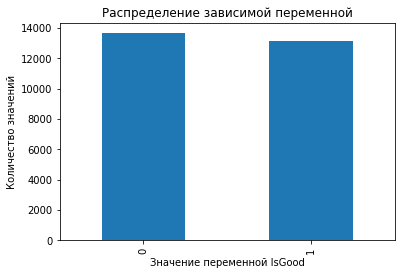

In [10]:
y.value_counts().plot(kind='bar')
plt.xlabel('Значение переменной IsGood')
plt.ylabel('Количество значений')
plt.title('Распределение зависимой переменной')

Корреляция между независимыми переменными нам не так интересна, а корреляция независимых переменных с $IsGood$ может быть полезна для дальнейшего анализа (например, выделения релевантных признаков). 

In [11]:
correlated_features = ['notbe'] + list(df.corr().loc['notbe'].abs().sort_values(ascending=False).iloc[1:11].index)
sub_df = df[correlated_features]
sub_df.corr().iloc[0,1:]

count_days_since_last_visit     -0.356848
CALDAYDATE                      -0.321856
recency                         -0.289468
visit_3m_cnt                    -0.209041
visit_12m_cnt                   -0.164215
frequency                        0.149810
card_21d_amt                     0.143937
visit_6m_cnt                    -0.133295
cnt_days_last_points_increase   -0.128254
LSTKNBDT                        -0.113228
Name: notbe, dtype: float64

Видим, что самая большая корреляция с "количеством дней с последнего посящения", "c датой последнего посеящения", "c количеством визита за последние 3 и 12 месяцев", что очень логично. 

Разбиваем признаки на зависимые и не зависимые и делим выборку на две части: обучающую и тестовую

In [12]:
# Откладываем 20% данных для тестовой выборки. Валидируемся кросс-валидацией на 6 фолдов на train-наборе

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 30)

In [13]:
smp = SimpleImputer(strategy = 'median', fill_value = 0)
x_train = smp.fit_transform(x_train)
x_test = smp.transform(x_test)

In [14]:
iso_forest = IsolationForest(random_state = 42, bootstrap = True)
#Если True, отдельные деревья помещаются в случайные подмножества обучающих данных, 
#выбранных с заменой. предназначенный для улучшения стабильности и точности алгоритмов
#Если задан стандартный тренировочный наборD размера n, бэггинг образует m новых
#тренировочных наборов D_{i}, каждый размером n′, путём выборки из D равномерно и
#с возвратом. При сэмплинге с возвратом некоторые наблюдения могут быть повторены в каждой D_{i}D_{i}.
# выбросы ближе к корнб дерева
outliers = iso_forest.fit_predict(x_train, y_train)
x_train = pd.DataFrame(data = x_train, columns = train_columns[1:])
x_train['outliers'] = outliers
x_train = x_train[x_train['outliers'] == 1]
x_train = x_train.drop('outliers', axis = 1)
y_train = y_train[outliers == 1]
x_train.replace(-np.inf, 0, inplace = True)
x_train.replace(np.inf, 0, inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [15]:
from sklearn.preprocessing import MinMaxScaler, Imputer
# Нормализация
scaler = MinMaxScaler(feature_range = (0, 1))

In [16]:
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
columns = df.columns
X_columns =columns[:-1]
x_test = pd.DataFrame(data = x_test, columns = X_columns[1:])
x_train = pd.DataFrame(data = x_train, columns =X_columns[1:])

# Постановка задачи

Дано: обучающая выборка --- $\mathsf{(x_1,\ldots, x_n) \subset X}$, $\mathsf{y_i=y(x_i), ~i=1,\ldots,n}$ --- известные ответы. 

Обучающая выборка: $\mathbb{X}_\mathsf{n}=\mathsf{(x_i,y_i)_{i=1}^n},~\mathsf{x_i}\in \mathbb{R}^\mathsf{p},~ \mathsf{y_i}\in \{-1,+1\}.$

Найти: $\mathsf{a:X\to Y}$ --- функцию (decision function), приближающую $\mathsf{y}$ на всем множестве $\mathsf{X}$. 

$\mathsf{f(x,w)}$ --- разделяющая (дискриминантная) функция, $\mathsf{w}\in\mathbb{R}^\mathsf{p}$. 

$\mathsf{a(x,w)=\sign f(x,w)}$ --- классификатор. 

$\mathsf{f(x,w)}=0$ --- разделяющая поверхность. 

$\mathsf{M_i(w)=y_if(x_i,w)}$ --- \alert{отступ} объекта $\mathsf{x_i}$. 

Если $\mathsf{M_i(w)<0},$ то классификатор ошибается на $\mathsf{x_i}$.

$$Q(\mathsf{w)=\sum \limits_{i=1}^n [M_i(w)<0]}\le \tilde Q(\mathsf{w)=\sum \limits_{i=1}^n\mathcal{L}(M_i(w)) \to \min \limits_{w}}$$


In [45]:
x_train.head()

,sex,first_purchase_date,age,customer_month,customer_year,purchase_prefer_visit_time,count_days_since_last_visit,visit_1m_cnt,visit_3m_cnt,visit_6m_cnt,...,PAYSCASH,PAYSCRED,PAYSCERT,CHQSKUCOUNT,GOODBONUSSUM,CHEQBONUSSUM,SUMCASD,visit_12m_cnt,count_days_between_visits,mean_check
0,1.0,0.057231,0.750000,0.058824,0.000000,1.0,0.068966,0.25,0.285714,0.375,...,0.248824,0.258992,0.0,0.00,0.271493,0.0,0.341200,0.375,0.407407,0.071895
1,1.0,0.940449,0.706081,0.941176,0.857143,0.5,0.137931,0.00,0.142857,0.250,...,0.248824,0.429679,0.0,0.24,0.314480,0.0,0.340932,0.625,0.777778,0.058824
2,1.0,0.159319,0.716216,0.164706,0.142857,0.5,0.862069,0.00,0.142857,0.500,...,0.248824,0.499976,0.0,0.44,0.361991,0.0,0.341133,1.000,0.074074,0.137255
3,0.0,0.935808,0.777027,0.941176,0.857143,0.5,0.275862,0.00,0.142857,0.250,...,0.248824,0.345900,0.0,0.16,0.300905,0.0,0.341066,0.625,0.888889,0.084967
4,0.0,0.002707,0.854730,0.011765,0.000000,0.5,0.275862,0.00,0.142857,0.125,...,0.248824,0.486976,0.0,0.12,0.402715,0.0,0.341133,0.000,0.000000,0.111111


## Отбор признаков


### Feature selection и extraction.
#### Feature selection:
Уменьшает количество признаков. Выбор признаков с наибольшей «важностью» / влиянием на целевую переменную из набора существующих функций. Это может быть сделано с помощью различных методов: например, линейная регрессия, деревья решений.
#### Feature extraction: 
Добавляет признаки, которые вычисляются из других объектов, которые трудно анализировать напрямую / не сопоставим напрямую (например, изображения, временные ряды и т. Д.). В примере временного ряда могут быть использованы некоторые простые функции. пример: длина временного ряда, период, среднее значение, стандартное значение и т. д.


## Feature extraction:
Давайте посмотрим как выглядет обработанные данные.

In [45]:
from sklearn.decomposition import PCA

In [46]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_train)
X_PC = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])#

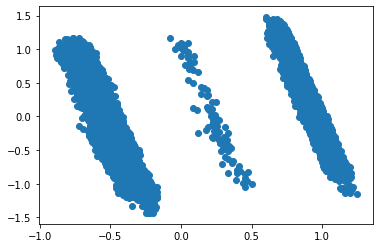

In [47]:
plt.scatter(X_PC.PC1,X_PC.PC2)

Видим, что классы разделимы.

Для визуализации корреляционной матрицы будем использовать "тепловую карту" 
heatmap которая показывает степень корреляции различными цветами:

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
sns.set(style="ticks")

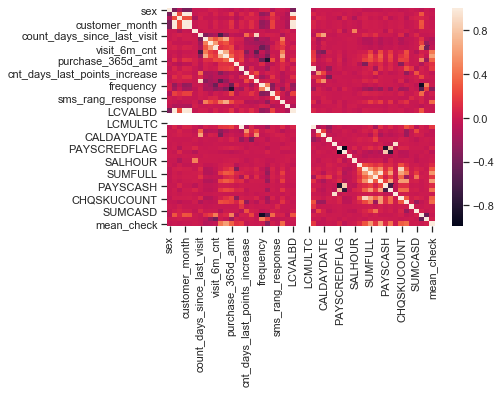

In [49]:
sns.heatmap(x_train.corr())

Корреляционная матрица позволяет понять зависимость между признаками. Не менее важно понять насколько значения целевого признака разделимы в рамках исходных признаков. Для ответа на этот вопрос используется матрица рассеяния (scatter matrix). По диагонали матрицы выводятся гистограммы распределения признаков, другие элементы матрицы показывают гистограмму рассеяния (при этом точки относящиеся к различным значениям целевого признака выделяются разными цветами).

## Feature selection 
Для отбора наиболее информативных признаков воспользуемся критерием Хи-квадрат и методом SelectKBest. Для примера отберем 10 признаков, чтобы был простор для дальнейшей обработки переменных, но в то же время, чтобы не было откровенной лишних признаков.
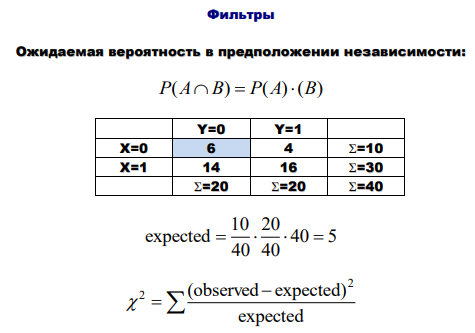


In [50]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit_transform(x_train)
chi_selector = SelectKBest(chi2, k=10)
#y_train=y_train.astype('int')# y тип object, поэтому sklearn не может распознать его тип

In [51]:
chi_selector.fit(X_norm,y_train)

SelectKBest(k=10, score_func=<function chi2 at 0x0000028B959B70D0>)

In [52]:
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

10 selected features


In [53]:
X_train_removed = x_train[chi_feature]
X_test_removed = x_test[chi_feature]

После того, как будут применены все известные алгоритмы, необходимо сравнить их между собой. Для этого нужно выбрать метрику точности алгоритма. Их существует несколько, каждая имеет плюсы и минусы.

1) Accuracy. Пусть после процедуры классификации мы знаем, сколько объектов было определено правильно, а сколько - неправильно. При этом нам важно знать, сколько объектов было классифицировано как $True positive (y=1, \hat{y}=1), False Positive (y=0, \hat{y}=1), True Negative (y=0, \hat{y}=0), False Negative (y=1, \hat{y}=0)$. 

Тогда $$accuracy=\frac{TP+TN}{TP+TN+FN+FP}.$$ 

Таким образом, точность показывает долю правильно классифицированных объектов.


2) Precision - она же точность. Показывает долю объектов, классифицированных как positive, которые на самом деле и есть positive, или $$precision=\frac{TP}{TP+FP}.$$


3) Recall - она же полнота. Показывает долю объектов, которые классифицированы как positive по отношению ко всем объектам этого класса, которые есть в выборке, или $$recall=\frac{TP}{TP+FN}.$$

4) ROC-AUC. Метрика, которая не зависит от баланса классов и вероятности, которую мы приняли как пороговую, чтобы определять, к какому классу принадлежит объект. ROC-AUC показывает зависимость $Precision$ от заданной наперед возможности ошибиться. Таким образом, ROC-кривая строится в координатах $\frac{FP}{FP+TP}$ по горизонтали и $Precision$ по вертикали. Чем больше площадь под этой кривой, она же $AUC$, тем точнее модель.

# LogisticRegression


В качестве аппроксимации пороговой функции потерь берется логарифмическая функция потерь $\mathcal{L}(\mathsf{M})=\log(1+e^{-\mathsf{M}}).$ 

Заметим, что во всех методах мы стремимся минимизировать функционал ошибок, каждый раз разный.
Для логистической регрессии таким функционалом является

$$Q(x,\bar{y},\bar{w})=\sum_{i=1}^{n}\log(1+exp(-y_i\bar{w^T}\bar{x_i})\to \min \limits_{\bar{w}}$$

При использовании метода логистической регрессии в Python необходимо указать следующие параметры:

1) $C=\frac{1}{\lambda}$, параметр регуляризации. Чем больше $C$, тем меньше $\lambda$, тем слабее регуляризация, так как за сложность мы штрафуем меньше. 

Проблемы: Признаков намного больше, чем объектов; Мультиколлинеарность признаков --- Таким образом, очень много различных векторов дадут близкие значения функционала качества, но при этом коэффициенты могут существенно отличаться. 

$$\mathsf{Q(w)=-\sum\limits_{i=1}^n [y_i\log (\sigma_w(x_i)+(1-y_i))\log (1-\sigma_w(x_i))]}$$

$\sigma=\frac{1}{1+\exp(- y\langle x,w \rangle )}$ (сигмоидная функция)

2) Норма, по которой происходит регуляризация. По умолчанию выбрана $L_2$, но можно также выбрать $L_1$ (что соответствует Lasso).

Регуляризация в логистической регрессии:
$$L2: \mathsf{Q_\tau(w)=Q(w)+\frac{\lambda}{2}\sum\limits_{j=1}^p w_j^2 \to \min\limits_w}$$
    
$$L1: \mathsf{Q_\tau(w)=Q(w)+\lambda\sum\limits_{j=1}^p |w_j| \to \min\limits_w}$$

3) Class_weight - поправка на веса. В случае, когда выбрано 'balanced', учитывается, сколько элементов первого и второго классов встретилось в тренировочной выборке. Дальше предполагается, что такой же баланс наблюдается и на тестовой выборке. 


Параметр $\mathsf{\lambda}$ можно подбирать с помощью кросс-валидации. 

class sklearn.linear_model.LogisticRegression(penalty=’l2’, dual=False,tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1,class_weight=None, random_state=None, solver=’liblinear’,max_iter=100)
	
$!$ penalty: ’l1’, ’l2’(default = ’l2’),– вид регуляризации, “lbfgs”и “newton-cg” поддреживают только L2 регуляризвцию.

$!$ dual: bool(default = False), прямая или дуальная задача оптимизации. Дуальная формулировка поддерживается только с liblinear. Лучше использовать dual=False, когдаn_samples>n_features.

$!$ C: float(default=1.0)– параметр регуляризации, должен быть положительным float. Меньшее С обеспечивает более сильную регуляризацию.

$!$ fit_intercept : bool(default = True) – определяет добавлять ли константу к решающей функции.

$!$ intercept_scaling : float(default = 1) – полезен, только если используется libliner, если self.fit_intercept=True, то векторx, описывающий объект, становится равным [x,self.intercept_scaling].

$!$ class_weight :
dict or ‘balanced’(default=None)– веса, ассоциированные с классами, записываются в форме{class_label: weight}. Если параметр не указан, все веса предполагаются равными 1. ’balanced’ использует значения y, чтобы автоматически установить веса обратнопропорционально частотам класса во входных данных.

$!$ random_state: 
int seed, RandomState instance, or None(default) – для инициализации генератора псевдослучайных чисел при перемешивании данных.

$!$ solver : ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’(default =’liblinear’), – алгоритм, который используется для решения проблемы оптимизации.


$!$ max_iter : int(default=100) – используется только для newton-cg, sag и lbfgs. Максимальное число итераций.

$!$ multiclass: ’ovr’, ’multinimial’. При использовании ’ovr’ используется стратегия OneVsRest для мультиклассовойклассификации. Иначе, минимизируемая функция потерь это multinomial loss, которая учитывает полное распределение вероятностей.



In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score

def LogReg(X_train_removed,y_train,X_test_removed,y_test):
    logreg = LogisticRegression()
    logreg.fit(X_train_removed, y_train)
    score_train = logreg.score(X_train_removed, y_train)
    score_test = logreg.score(X_test_removed, y_test)
    
    
    predictionsLOGIT = logreg.predict_proba(X_test_removed)[:,1]
    predictionsLOGIT_train = logreg.predict_proba(X_train_removed)[:,1]
    
    roc_auc_train=roc_auc_score(y_train,predictionsLOGIT_train)
    roc_auc=roc_auc_score(y_test,predictionsLOGIT)
    
    log_pred = pd.Series(predictionsLOGIT)
    mean_pred=log_pred.mean()
    log_pred = log_pred.apply(lambda x: 1 if x >= mean_pred else 0)
    
    
    accuracy=accuracy_score(y_test, log_pred)
    recall=recall_score(y_test, log_pred)
    precision=precision_score(y_test, log_pred)
    data=pd.DataFrame((roc_auc_train,roc_auc,accuracy,recall,precision), 
                 index = ['roc_auc_train','roc_auc_test','accuracy','recall','precision'],columns = ['LogisticRegression'])    
    return(data) 
LG = LogReg(X_train_removed,y_train,X_test_removed,y_test)
LogReg(X_train_removed,y_train,X_test_removed,y_test)

,LogisticRegression
roc_auc_train,0.796034
roc_auc_test,0.788378
accuracy,0.723452
recall,0.720288
precision,0.724975


###### Для оптимизации гиперпараметров воспользуемся методом поиска по сетке.


In [75]:

parameters = {
    "C":np.logspace(-3,3,7), #[1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]
    "penalty":["l1","l2"],
    "class_weight":["balanced"]
    }

clf = GridSearchCV(LogisticRegression(random_state=42), parameters, cv=6)

In [76]:
%%time
clf.fit(X_train_removed, y_train)
print(clf.score(X_train_removed, y_train), clf.score(X_test_removed, y_test))
print(clf.best_params_)

0.7356546455853615 0.7239492663516538
{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1'}
Wall time: 11min 24s


In [77]:
predictionsGS = clf.predict_proba(X_test_removed)[:,1]
roc_auc_score(y_test,predictionsGS)

0.790990472797623

In [78]:
predictionsGS_train = clf.predict_proba(X_train_removed)[:,1]
roc_auc_score(y_train,predictionsGS_train)

0.8000780609722993

In [79]:
data=pd.DataFrame((roc_auc_score(y_train,predictionsGS_train),roc_auc_score(y_test,predictionsGS)), 
                 index = ['train','test'],columns = ['LogisticRegression'])  

Так же логично сразу проверить деревья решений. Чтобы не использовать точную подстройку параметров дерева, запустим случайный лес, так как он автоматически борется с переобучением за счет усреднения результатов отдельных моделей.

# RandomForestClassifier

##  Постановка задачи:

Пусть $X\in\mathbb{R}^{nxp}$ -матрица данных с p признеаками для n индивидов. $Y=\{0,1\}$ - ответы.

Идея: разбить пространство признаков, т.е. совокупность всех возможных значений $X_1,...,X_p$ на $J$ непересекающихся областей $R_1,...,R_j$ (многомерных прямоугольников), которые выбираются исходя из условия:

$$E=1-\max_k(\hat{p}_{jk})->\min_{R_1,...,R_j}$$

где 

$$\hat{p}_{jk}=\frac{1}{|R_j|}\sum_{x_i\in R_j}\mathbb{1}_{(y_i=k)},\;\;\;j=1,...,J$$

На практике чаще всего используют два других (информационных) критерия для фиксированного j

- $G=\sum_{k=1}^K\hat{p}_{jk}(1-\hat{p}_{jk})$ - индекс Джини

- $D=-\sum_{k=1}^K\hat{p}_{jk}\log\hat{p}_{jk}$ - критерий перекрестной энтропии

Предсказание для объекта х:

$$f(x)=arg\max_{k\in Y}\hat{p}_{jk}$$

Процесс построения решающих деревьев представляет собой жадный алгоритм, работающий до выполнения
критерия останова.

Пусть на некотором шаге алгоритма необходимо разбить вершину m, в которой оказалась выборкa $X_m$ ,
на две. В качестве условия разбиения используется сравнение j-го признака с порогом t:

$$[x^j\leq t]$$

Параметры j и t выбираются исходя из условия минимизации функции ошибки $Q(X_m,j,t)$:

$$Q(X_m,j,t)->\min_{j,t}$$

Параметры j и t можно подбирать перебором. Действительно, признаков конечное число, а из всех возможных
значений порога t можно рассматривать только те, при которых получаются различные разбиения. Можно
показать, что таких значений параметра t столько, сколько различных значений признака $x^j$ на обучающей
выборке.

После того, как параметры были выбраны, множество $X_m$ объектов из обучающей выборки разбивается
на два множества

$$X_l=\{x\in X_m|[x^j\leq t]\},\;\;\;\;\;\;X_r=\{x\in X_m|[x^j> t]\}$$

каждое из которых соответствует своей дочерней вершине.

Предложенную процедуру можно продолжить для каждой из дочерних вершин: в этом случае дерево
будет все больше и больше углубляться. Такой процесс рано или поздно должен остановиться, и очередная
дочерняя вершина будет объявлена листком, а не разделена пополам. Этот момент определяется критерием
остановки. Существует много различных вариантов критерия остановки:

- Если в вершину попал только один объект обучающей выборки или все объекты принадлежат одному
классу (в задачах классификации), дальше разбивать не имеет смысла.
- Можно также останавливать разбиение, если глубина дерева достигла определенного значения.

Рандомизировать процесс построения можно, если в задаче поиска оптимальных параметров выбирать j
из случайного подмножества признаков размера q. Оказывается, что этот подход действительно позволяет
сделать деревья менее коррелированными.

Критерий ошибки записывается следующим образом:

$$Q(X_m,j,t)=\frac{|X_l|}{|X_m|}H(X_l)+\frac{|X_r|}{|X_m|}H(X_r)$$

и состоит из двух слагаемых, каждое из которых соответствует своему листу.
Функция H(X) называется критерием информативности.



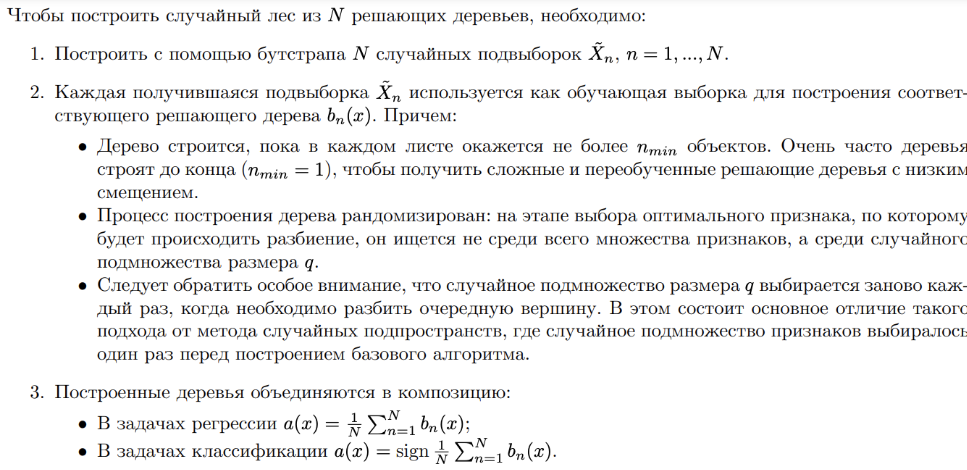

## Параметры 
Случайный лес представляет собой композицию деревьев, где на каждом шаге разбиение происходит по признаку из рандомного подмножества признаков размерности $q$.
Далее рассмотрим несколько параметров, на которые в первую очередь стоит обратить внимание при построении модели:

1) n_estimators - количество деревьев в "лесу". Чем выше число, тем лучше, но важно знать, что это сложнее в вычислительном отношении и занимает больше времени для запуска вашего кода.

2) max_depth -  максимальная глубина дерева. Если None, то узлы расширяются до тех пор, пока все листья не станут чистыми или пока все листья не будут содержать меньше чем min_samples_split samples.

3) min_samples_split - Минимальное количество элементов, попадающих в каждое поддерево. необязательный (по умолчанию = 2)

4) min_samples_leaf - Минимальное количество элементов в вершине (в листовом узле) для дальшнейшего разбиения.  необязательный (по умолчанию = 1)

5) max_features - Количество функций, которые следует учитывать при поиске лучшего разделения. По умолчанию он соответствует $\sqrt n$, где $n$-количество признаков, что является оптимальным значением.

6) min_weight_fraction_leaf -  Минимальная взвешенная доля общей суммы весов (всех входных выборок), необходимая для конечного узла. Образцы имеют одинаковый вес, когда sample_weight не указан.

7) criterion — поскольку у нас теперь задача классификации, то по дефолту выбран критерий "gini" (можно выбрать "entropy")
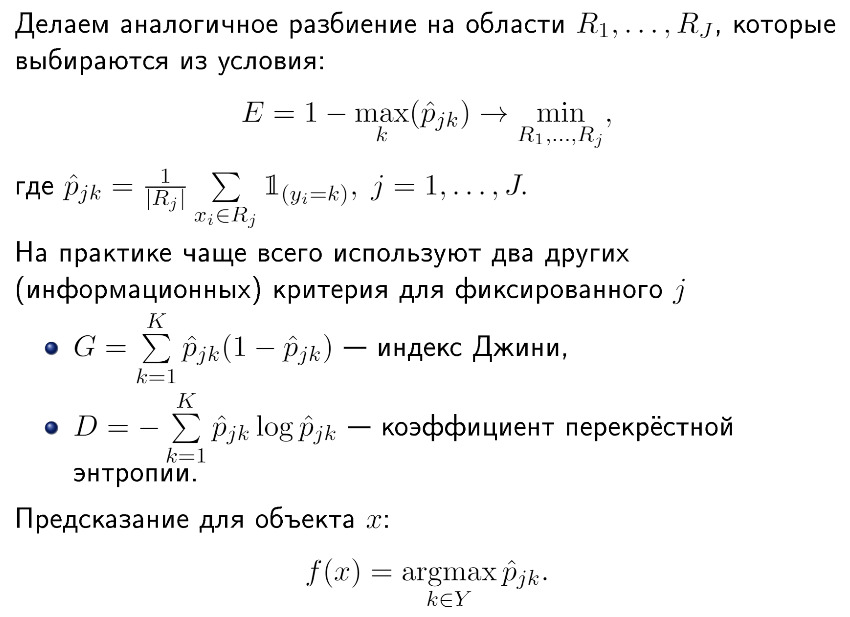


In [60]:
X_train_removed =x_train 
X_test_removed =x_test

In [61]:
from sklearn.ensemble import RandomForestClassifier

def RandForest(X_train_removed,y_train,X_test_removed,y_test):
    modelRF = RandomForestClassifier(n_estimators=100, max_features=1, random_state=1)
    modelRF.fit(X_train_removed, y_train)
    score_train = modelRF.score(X_train_removed, y_train)
    score_test =modelRF.score(X_test_removed, y_test)
    
    predictionsRF = modelRF.predict_proba(X_test_removed)[:,1]
    roc_auc=roc_auc_score(y_test,predictionsRF)
    
    predictionsRF_train = modelRF.predict_proba(X_train_removed)[:,1]
    roc_auc_train=roc_auc_score(y_train,predictionsRF_train)
    
    
    rf_pred = pd.Series(predictionsRF)
    mean_pred=rf_pred.mean()
    rf_pred = rf_pred.apply(lambda x: 1 if x >= mean_pred else 0)
    
    accuracy=accuracy_score(y_test, rf_pred)
    recall=recall_score(y_test, rf_pred)
    precision=precision_score(y_test, rf_pred)
    
    data=pd.DataFrame((roc_auc_train,roc_auc,accuracy,recall,precision), 
                 index = ['roc_auc_train','roc_auc_test','accuracy','recall','precision'],columns = ['RandomForestClassifier']) 
 
    return (data)
RF=RandForest(X_train_removed,y_train,X_test_removed,y_test)
RandForest(X_train_removed,y_train,X_test_removed,y_test)

,RandomForestClassifier
roc_auc_train,1.000000
roc_auc_test,0.867594
accuracy,0.788112
recall,0.768523
precision,0.799948


In [62]:
parameters_rf = {
    "max_depth": [4,7,10],
    "min_samples_split": [2,3,4,10], 
    "min_samples_leaf": [2,3,4,10],
    "n_estimators": [30,60,90],
    "criterion": ["gini", "entropy"]
}
clf_rf = GridSearchCV(RandomForestClassifier(random_state=1), parameters_rf, cv=6)

In [64]:
%%time
clf_rf.fit(x_train, y_train)
print(clf_rf.score(X_train_removed, y_train), clf_rf.score(X_test_removed, y_test))
print(clf_rf.best_params_)

0.8632676022976254 0.8270330763491669
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 90}
Wall time: 32min 23s


In [65]:
predictionsrf = clf_rf.predict_proba(X_test_removed)[:,1]
roc_auc_score(y_test,predictionsrf)

0.9112578579009478

In [66]:
predictionsrf_train = clf_rf.predict_proba(X_train_removed)[:,1]
roc_auc_score(y_train,predictionsrf_train)

0.9472817760467459

In [81]:
data['RandomForestClassifier'] = (roc_auc_score(y_train,predictionsrf_train),roc_auc_score(y_test,predictionsrf))

# Neural Network (Keras)

Нейронная сеть — это универсальная модель, решающая широкий класс задач регрессии и классификации.

###### Нейронная сеть и задача классификации
Пусть $\{(x_i,y_i)\}^l_{i=1}$ — обучающая выборка в задаче бинарной классификации, $x_i\in \mathbb{R}^d$ и $y_i\in \{1, −1\}$ - признаковое описание и метка класса для $i$-го объекта соответственно. Требуется построить разделяющую поверхность

$$a(x) -> y \in \{−1, 1\}$$

которая отделяет объекты одного класса от объектов другого класса таким образом, что, если $a(x) > 0$, то объект $x$ принадлежит классу $y = +1$, и, если $a(x) ≤ 0$, то $x$ принадлежит классу $y = −1$.

Задача выглядит следующим образом:
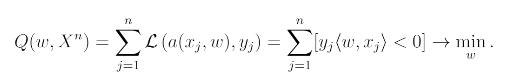

Нейронная сеть считается универсальной моделью, так как она способна аппроксимировать любые поверхности. 





## Двуслойная нейронная сеть

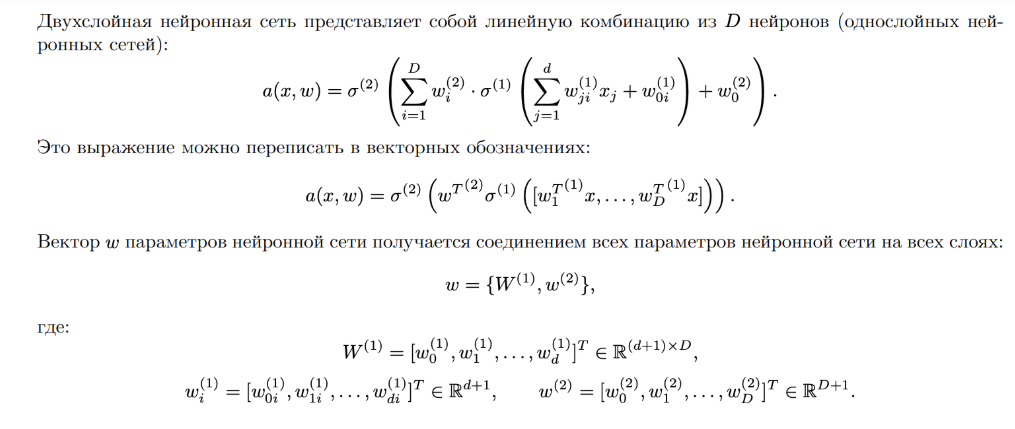

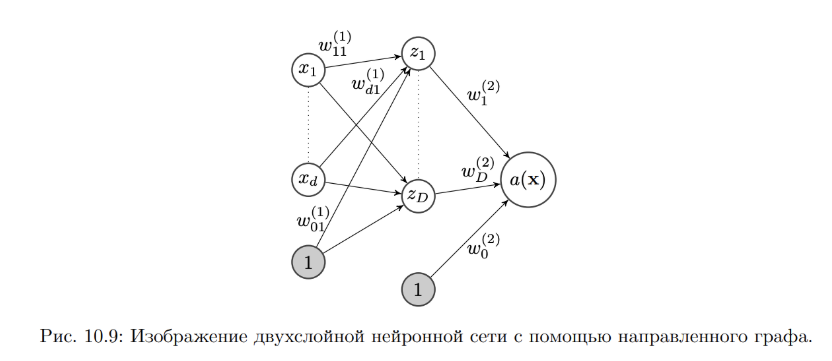

- $x$ - исходный объект, 

- $x_j$ -- соответствующий признак,

- $d$ -  количество нейронов во входном слое сети, совпадающее с количеством признаков,

- $D$ -  количество нейронов в скрытом слое сети,

- $\sigma^{(1)}, \sigma^{(2)}$ -- функции активации.



Обратное распространение ошибки BackProp
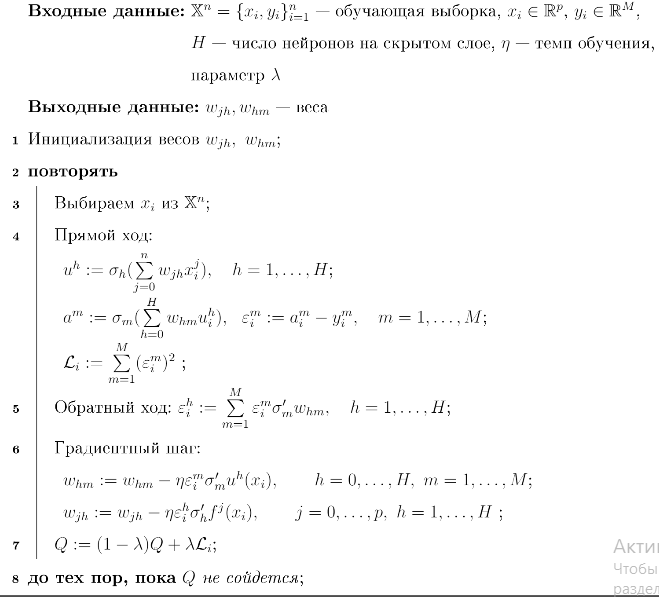

## В качестве функции активации на скрытом слое сети используется линейная функция. На выходном слое сети используется функция активации sigmoid:

$$a(x,w)=\sigma(w^Tx)=\frac{1}{1+\exp(-w^Tx)}$$

Эта функция определяет вероятность принадлжености некоторого заданного объекта х к классу у=1 при заданных параметрах w:

$$\sigma(w^Tx)=P(y=1|w,x)$$
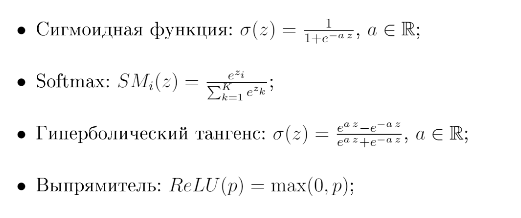

keras.layers.Dense(units, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)

- units - Этот параметр является положительным целым числом, которое обозначает выходной размер слоя. Это самый важный параметр, который мы можем установить для этого слоя. Параметр unit фактически определяет размер матрицы весов и вектора смещения (вектор смещения будет того же размера, но матрица весов будет рассчитываться на основе размера входных данных, чтобы произведение точек получило данные, которые имеют выходной размер, ед.)

- activation - Этот параметр устанавливает поэлементную функцию активации, которая будет использоваться в плотном слое. По умолчанию мы видим, что для него установлено значение Нет. Это означает, что по умолчанию это линейная активация.



In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense


In [18]:
# K fold validation

classifier = Sequential()
    #First Hidden Layer
classifier.add(Dense(8, activation='relu', kernel_initializer='random_normal', input_dim=52))#5606
    
    #Second  Hidden Layer
   # classifier.add(Dense(8, activation='relu', kernel_initializer='random_normal'))
#Output Layer
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
#Compiling the neural network
classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])


In [19]:
#Fitting the data to the training dataset
classifier.fit(x_train,y_train, batch_size=10, epochs=100)

Epoch 1/100
16887/16887 [==============================] - ETA: 2:50 - loss: 0.6942 - accuracy: 0.40 - ETA: 4s - loss: 0.6929 - accuracy: 0.5179 - ETA: 2s - loss: 0.6923 - accuracy: 0.55 - ETA: 2s - loss: 0.6906 - accuracy: 0.55 - ETA: 1s - loss: 0.6881 - accuracy: 0.57 - ETA: 1s - loss: 0.6841 - accuracy: 0.58 - ETA: 1s - loss: 0.6788 - accuracy: 0.60 - ETA: 1s - loss: 0.6731 - accuracy: 0.61 - ETA: 1s - loss: 0.6680 - accuracy: 0.62 - ETA: 1s - loss: 0.6622 - accuracy: 0.63 - ETA: 1s - loss: 0.6566 - accuracy: 0.63 - ETA: 1s - loss: 0.6514 - accuracy: 0.64 - ETA: 0s - loss: 0.6455 - accuracy: 0.65 - ETA: 0s - loss: 0.6426 - accuracy: 0.65 - ETA: 0s - loss: 0.6394 - accuracy: 0.65 - ETA: 0s - loss: 0.6357 - accuracy: 0.66 - ETA: 0s - loss: 0.6323 - accuracy: 0.66 - ETA: 0s - loss: 0.6293 - accuracy: 0.66 - ETA: 0s - loss: 0.6249 - accuracy: 0.67 - ETA: 0s - loss: 0.6233 - accuracy: 0.67 - ETA: 0s - loss: 0.6214 - accuracy: 0.67 - ETA: 0s - loss: 0.6197 - accuracy: 0.67 - ETA: 0s - los

16887/16887 [==============================] - ETA: 5s - loss: 0.3979 - accuracy: 0.90 - ETA: 1s - loss: 0.4863 - accuracy: 0.77 - ETA: 1s - loss: 0.5035 - accuracy: 0.75 - ETA: 1s - loss: 0.4942 - accuracy: 0.76 - ETA: 1s - loss: 0.4936 - accuracy: 0.77 - ETA: 1s - loss: 0.4920 - accuracy: 0.77 - ETA: 1s - loss: 0.4927 - accuracy: 0.77 - ETA: 1s - loss: 0.4911 - accuracy: 0.77 - ETA: 1s - loss: 0.4941 - accuracy: 0.76 - ETA: 0s - loss: 0.4950 - accuracy: 0.76 - ETA: 0s - loss: 0.4950 - accuracy: 0.76 - ETA: 0s - loss: 0.4942 - accuracy: 0.76 - ETA: 0s - loss: 0.4930 - accuracy: 0.76 - ETA: 0s - loss: 0.4950 - accuracy: 0.76 - ETA: 0s - loss: 0.4941 - accuracy: 0.76 - ETA: 0s - loss: 0.4937 - accuracy: 0.76 - ETA: 0s - loss: 0.4936 - accuracy: 0.76 - ETA: 0s - loss: 0.4934 - accuracy: 0.76 - ETA: 0s - loss: 0.4926 - accuracy: 0.77 - ETA: 0s - loss: 0.4910 - accuracy: 0.77 - ETA: 0s - loss: 0.4903 - accuracy: 0.77 - ETA: 0s - loss: 0.4894 - accuracy: 0.77 - ETA: 0s - loss: 0.4903 - accu

16887/16887 [==============================] - ETA: 3s - loss: 0.5923 - accuracy: 0.60 - ETA: 1s - loss: 0.4652 - accuracy: 0.79 - ETA: 1s - loss: 0.4593 - accuracy: 0.80 - ETA: 1s - loss: 0.4631 - accuracy: 0.79 - ETA: 1s - loss: 0.4582 - accuracy: 0.79 - ETA: 1s - loss: 0.4510 - accuracy: 0.80 - ETA: 1s - loss: 0.4504 - accuracy: 0.80 - ETA: 1s - loss: 0.4527 - accuracy: 0.80 - ETA: 1s - loss: 0.4463 - accuracy: 0.80 - ETA: 0s - loss: 0.4452 - accuracy: 0.80 - ETA: 0s - loss: 0.4479 - accuracy: 0.80 - ETA: 0s - loss: 0.4502 - accuracy: 0.80 - ETA: 0s - loss: 0.4506 - accuracy: 0.80 - ETA: 0s - loss: 0.4523 - accuracy: 0.79 - ETA: 0s - loss: 0.4533 - accuracy: 0.79 - ETA: 0s - loss: 0.4543 - accuracy: 0.79 - ETA: 0s - loss: 0.4529 - accuracy: 0.79 - ETA: 0s - loss: 0.4500 - accuracy: 0.79 - ETA: 0s - loss: 0.4502 - accuracy: 0.79 - ETA: 0s - loss: 0.4484 - accuracy: 0.79 - ETA: 0s - loss: 0.4486 - accuracy: 0.79 - ETA: 0s - loss: 0.4503 - accuracy: 0.79 - ETA: 0s - loss: 0.4492 - accu

16887/16887 [==============================] - ETA: 5s - loss: 0.5937 - accuracy: 0.60 - ETA: 1s - loss: 0.4114 - accuracy: 0.82 - ETA: 1s - loss: 0.4184 - accuracy: 0.82 - ETA: 1s - loss: 0.4164 - accuracy: 0.82 - ETA: 1s - loss: 0.4151 - accuracy: 0.82 - ETA: 1s - loss: 0.4177 - accuracy: 0.82 - ETA: 1s - loss: 0.4247 - accuracy: 0.81 - ETA: 1s - loss: 0.4264 - accuracy: 0.81 - ETA: 1s - loss: 0.4259 - accuracy: 0.81 - ETA: 0s - loss: 0.4260 - accuracy: 0.81 - ETA: 0s - loss: 0.4250 - accuracy: 0.81 - ETA: 0s - loss: 0.4250 - accuracy: 0.81 - ETA: 0s - loss: 0.4242 - accuracy: 0.81 - ETA: 0s - loss: 0.4268 - accuracy: 0.81 - ETA: 0s - loss: 0.4259 - accuracy: 0.81 - ETA: 0s - loss: 0.4284 - accuracy: 0.81 - ETA: 0s - loss: 0.4266 - accuracy: 0.81 - ETA: 0s - loss: 0.4286 - accuracy: 0.81 - ETA: 0s - loss: 0.4294 - accuracy: 0.80 - ETA: 0s - loss: 0.4292 - accuracy: 0.80 - ETA: 0s - loss: 0.4295 - accuracy: 0.80 - ETA: 0s - loss: 0.4306 - accuracy: 0.80 - ETA: 0s - loss: 0.4301 - accu

16887/16887 [==============================] - ETA: 5s - loss: 0.2392 - accuracy: 1.00 - ETA: 1s - loss: 0.4354 - accuracy: 0.78 - ETA: 1s - loss: 0.4340 - accuracy: 0.79 - ETA: 1s - loss: 0.4290 - accuracy: 0.80 - ETA: 1s - loss: 0.4232 - accuracy: 0.81 - ETA: 1s - loss: 0.4242 - accuracy: 0.81 - ETA: 1s - loss: 0.4240 - accuracy: 0.81 - ETA: 1s - loss: 0.4204 - accuracy: 0.81 - ETA: 1s - loss: 0.4225 - accuracy: 0.81 - ETA: 1s - loss: 0.4226 - accuracy: 0.81 - ETA: 0s - loss: 0.4264 - accuracy: 0.81 - ETA: 0s - loss: 0.4261 - accuracy: 0.81 - ETA: 0s - loss: 0.4239 - accuracy: 0.81 - ETA: 0s - loss: 0.4221 - accuracy: 0.81 - ETA: 0s - loss: 0.4228 - accuracy: 0.81 - ETA: 0s - loss: 0.4214 - accuracy: 0.81 - ETA: 0s - loss: 0.4198 - accuracy: 0.81 - ETA: 0s - loss: 0.4196 - accuracy: 0.81 - ETA: 0s - loss: 0.4180 - accuracy: 0.81 - ETA: 0s - loss: 0.4176 - accuracy: 0.81 - ETA: 0s - loss: 0.4166 - accuracy: 0.81 - ETA: 0s - loss: 0.4153 - accuracy: 0.81 - ETA: 0s - loss: 0.4156 - accu

16887/16887 [==============================] - ETA: 3s - loss: 0.8457 - accuracy: 0.70 - ETA: 1s - loss: 0.4458 - accuracy: 0.81 - ETA: 1s - loss: 0.4079 - accuracy: 0.83 - ETA: 1s - loss: 0.4151 - accuracy: 0.82 - ETA: 1s - loss: 0.4155 - accuracy: 0.82 - ETA: 1s - loss: 0.4101 - accuracy: 0.82 - ETA: 1s - loss: 0.4115 - accuracy: 0.81 - ETA: 1s - loss: 0.4057 - accuracy: 0.82 - ETA: 1s - loss: 0.4043 - accuracy: 0.82 - ETA: 1s - loss: 0.4038 - accuracy: 0.82 - ETA: 0s - loss: 0.4081 - accuracy: 0.81 - ETA: 0s - loss: 0.4056 - accuracy: 0.82 - ETA: 0s - loss: 0.4062 - accuracy: 0.82 - ETA: 0s - loss: 0.4055 - accuracy: 0.82 - ETA: 0s - loss: 0.4081 - accuracy: 0.81 - ETA: 0s - loss: 0.4084 - accuracy: 0.81 - ETA: 0s - loss: 0.4073 - accuracy: 0.81 - ETA: 0s - loss: 0.4081 - accuracy: 0.81 - ETA: 0s - loss: 0.4063 - accuracy: 0.82 - ETA: 0s - loss: 0.4031 - accuracy: 0.82 - ETA: 0s - loss: 0.4041 - accuracy: 0.82 - ETA: 0s - loss: 0.4038 - accuracy: 0.82 - ETA: 0s - loss: 0.4031 - accu

16887/16887 [==============================] - ETA: 5s - loss: 0.5435 - accuracy: 0.80 - ETA: 1s - loss: 0.3766 - accuracy: 0.83 - ETA: 1s - loss: 0.3981 - accuracy: 0.82 - ETA: 1s - loss: 0.3999 - accuracy: 0.82 - ETA: 1s - loss: 0.3952 - accuracy: 0.82 - ETA: 1s - loss: 0.3997 - accuracy: 0.81 - ETA: 1s - loss: 0.3953 - accuracy: 0.82 - ETA: 1s - loss: 0.3932 - accuracy: 0.82 - ETA: 1s - loss: 0.3941 - accuracy: 0.82 - ETA: 0s - loss: 0.3993 - accuracy: 0.82 - ETA: 0s - loss: 0.3958 - accuracy: 0.82 - ETA: 0s - loss: 0.3987 - accuracy: 0.82 - ETA: 0s - loss: 0.3969 - accuracy: 0.82 - ETA: 0s - loss: 0.3969 - accuracy: 0.82 - ETA: 0s - loss: 0.3973 - accuracy: 0.82 - ETA: 0s - loss: 0.3970 - accuracy: 0.82 - ETA: 0s - loss: 0.3969 - accuracy: 0.82 - ETA: 0s - loss: 0.3968 - accuracy: 0.82 - ETA: 0s - loss: 0.3968 - accuracy: 0.82 - ETA: 0s - loss: 0.3942 - accuracy: 0.82 - ETA: 0s - loss: 0.3947 - accuracy: 0.82 - ETA: 0s - loss: 0.3949 - accuracy: 0.82 - ETA: 0s - loss: 0.3956 - accu

16887/16887 [==============================] - ETA: 3s - loss: 0.3213 - accuracy: 0.80 - ETA: 1s - loss: 0.4043 - accuracy: 0.82 - ETA: 1s - loss: 0.3884 - accuracy: 0.83 - ETA: 1s - loss: 0.3869 - accuracy: 0.83 - ETA: 1s - loss: 0.3828 - accuracy: 0.83 - ETA: 1s - loss: 0.3860 - accuracy: 0.83 - ETA: 1s - loss: 0.3888 - accuracy: 0.82 - ETA: 1s - loss: 0.3874 - accuracy: 0.83 - ETA: 1s - loss: 0.3860 - accuracy: 0.83 - ETA: 1s - loss: 0.3880 - accuracy: 0.83 - ETA: 0s - loss: 0.3867 - accuracy: 0.83 - ETA: 0s - loss: 0.3845 - accuracy: 0.83 - ETA: 0s - loss: 0.3853 - accuracy: 0.83 - ETA: 0s - loss: 0.3844 - accuracy: 0.83 - ETA: 0s - loss: 0.3846 - accuracy: 0.83 - ETA: 0s - loss: 0.3858 - accuracy: 0.83 - ETA: 0s - loss: 0.3888 - accuracy: 0.83 - ETA: 0s - loss: 0.3896 - accuracy: 0.83 - ETA: 0s - loss: 0.3880 - accuracy: 0.83 - ETA: 0s - loss: 0.3869 - accuracy: 0.83 - ETA: 0s - loss: 0.3874 - accuracy: 0.83 - ETA: 0s - loss: 0.3857 - accuracy: 0.83 - ETA: 0s - loss: 0.3872 - accu

16887/16887 [==============================] - ETA: 3s - loss: 0.2693 - accuracy: 0.90 - ETA: 1s - loss: 0.3999 - accuracy: 0.82 - ETA: 1s - loss: 0.3965 - accuracy: 0.81 - ETA: 1s - loss: 0.4018 - accuracy: 0.81 - ETA: 1s - loss: 0.3941 - accuracy: 0.81 - ETA: 1s - loss: 0.3901 - accuracy: 0.82 - ETA: 1s - loss: 0.3897 - accuracy: 0.82 - ETA: 1s - loss: 0.3931 - accuracy: 0.82 - ETA: 1s - loss: 0.3933 - accuracy: 0.82 - ETA: 0s - loss: 0.3902 - accuracy: 0.82 - ETA: 0s - loss: 0.3893 - accuracy: 0.82 - ETA: 0s - loss: 0.3889 - accuracy: 0.82 - ETA: 0s - loss: 0.3903 - accuracy: 0.82 - ETA: 0s - loss: 0.3892 - accuracy: 0.82 - ETA: 0s - loss: 0.3878 - accuracy: 0.83 - ETA: 0s - loss: 0.3861 - accuracy: 0.83 - ETA: 0s - loss: 0.3871 - accuracy: 0.83 - ETA: 0s - loss: 0.3873 - accuracy: 0.83 - ETA: 0s - loss: 0.3891 - accuracy: 0.82 - ETA: 0s - loss: 0.3897 - accuracy: 0.82 - ETA: 0s - loss: 0.3916 - accuracy: 0.82 - ETA: 0s - loss: 0.3920 - accuracy: 0.82 - ETA: 0s - loss: 0.3905 - accu

In [20]:
eval_model=classifier.evaluate(x_train, y_train)
y_pred=classifier.predict(x_test)
mean_pred = y_pred.mean()
mean_pred

16887/16887 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 14us/step


0.49380437

In [21]:
y_pred =(y_pred>mean_pred)
y_pred_t=classifier.predict(x_train)

In [22]:
accuracy=accuracy_score(y_test, y_pred)
recall=recall_score(y_test, y_pred)
precision=precision_score(y_test, y_pred)
roc_auc_train=roc_auc_score(y_train, y_pred_t)
roc_auc_test=roc_auc_score(y_test, y_pred)
data_NN=pd.DataFrame((roc_auc_train,roc_auc_test,accuracy,recall,precision), 
                index = ['roc_auc_train','roc_auc_test','accuracy','recall','precision'],columns = ['NeuralNetwork']) 
data_NN

,NeuralNetwork
roc_auc_train,0.906375
roc_auc_test,0.817715
accuracy,0.817707
recall,0.787171
precision,0.838453


## Оптимизаторы

Adagrad - обнавляет параметры с оглядкой на то, насколько типичный признак он описывает. Хронит для каждого параметра в виде G =$\sum ()^2$ его обнавлений. Хотим уменьшить количества обновлений для элементов. 

- (-) может привести к большой сумме и обновления будут редко.
- (+) нет необходимости точно подбирать lr
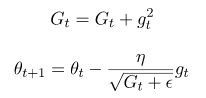

RMSprop: мы всё так же собираемся обновлять меньше веса, которые слишком часто обновляются, но вместо полной суммы обновлений, будем использовать усреднённый по истории квадрат градиента.
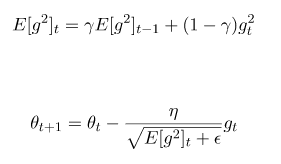


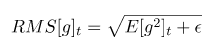

Adadelta: отличается от RMSprop тем, что мы добавляем в числитель стабилизирующий член пропорциональный  $RMS$ от $\Delta\theta_t$. На шаге $t$ мы ещё не знаем значение $RMS[\Delta \theta]_{t}$, поэтому обновление параметров происходит в три этапа, а не в два: сначала накапливаем квадрат градиента, затем обновляем $\theta$, после чего обновляем $RMS[\Delta \theta]$.

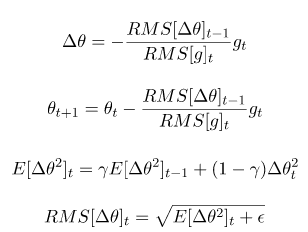



Adam: Он сочетает в себе и идею накопления движения и идею более слабого обновления весов для типичных признаков. 
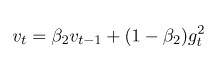
Легко заметить, что это уже знакомый нам $E[g^2]_t$, так что по сути тут нет отличий от RMSProp.

Важное отличие состоит в начальной калибровке \inline m_t и \inline v_t: 

та же проблема что и в RMSprop: если задать нулевое начальное значение, то они будут долго накапливаться, особенно при большом окне накопления $(0<< \beta_1<1, 0<< \beta_2 <1)$, а какие-то изначальные значения — это ещё два гиперпараметра. Никто не хочет ещё два гиперпараметра, так что мы искусственно увеличиваем  $m_t$ и $v_t$ на первых шагах (примерно  $0 <t<10$ для $ m_t и $0 <t <1000$ для $v_t$)

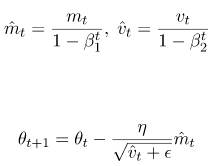

## Подбор параметров GridSearch

In [23]:
from keras.layers import Dropout #метод решения проблемы переобучения в нейронных сетях
from keras.wrappers.scikit_learn import KerasClassifier



In [24]:
parameters_NN ={'batch_size':[4,8,10,16,32,64],
'nb_epoch':[50,100,150],
'optimizer':['rmsprop','SGD','adam','Adagrad','Adadelta'],#
'units':[4,8,13]}

In [26]:
def build_classifierGS_Drop(optimizer, units):
    classifier = Sequential()
    #First Hidden Layer
    classifier.add(Dense(units=units, activation='relu', kernel_initializer='random_normal', input_dim=52)
    classifier.add(Dropout(rate=0.2))
    #Second  Hidden Layer
    #classifier.add(Dense(units=units, activation='relu', kernel_initializer='random_normal'))
#Output Layer
    classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
#Compiling the neural network
    classifier.compile(optimizer=optimizer,loss='binary_crossentropy', metrics =['accuracy'])
    return classifier
classifierGS_Drop = KerasClassifier(build_fn=build_classifierGS_Drop)

##  EarlyStopping 
Слишком много эпох может привести к переобучению учебного набора данных, в то время как слишком мало может привести к модели недостаточного соответствия. Ранняя остановка - это метод, который позволяет указать произвольно большое количество периодов обучения и прекратить обучение, как только производительность модели перестает улучшаться в наборе проверенных данных.

Функции обратного вызова вызываются после каждой эпохи обучения с помощью параметра callbacks, передаваемого методам fit.

In [27]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor = 'val_loss',#контролируемое значение
                          min_delta = 0,#минимальное изменение контролируемого значения.
                          patience = 3,# количество эпох без улучшений, после которых обучение будет остановлено
                          verbose = 1,#Чтобы обнаружить эпоху обучения, в которой обучение было остановлено,
                          restore_best_weights = True)# сохранить лучшие веса после остановки

## Dropout
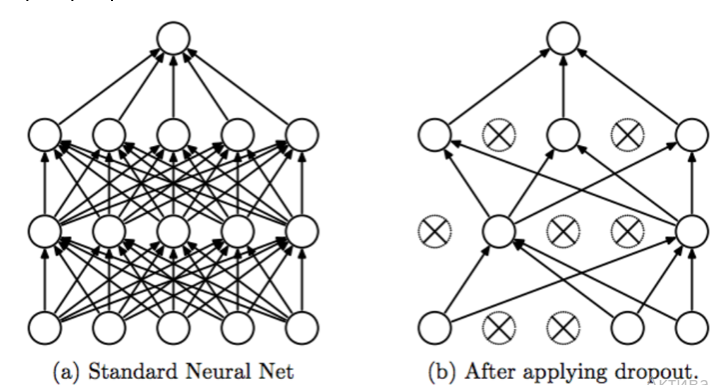

Основная идея слоя Dropout заключается в следующем: вместо обучения одной нейронной сети мы обучаем несколько нейронных сетей, а затем усредняем полученные результаты.

С помощью исключения из сети нейронов с вероятностью 𝑝 мы получаем сети для обучения. Таким образом, вероятность того, что нейрон останется в сети, составляет 1 − 𝑝.

Выбрасывание нейрона из сети означает, что при любых входных данных или параметрах
он возвращает 0.

Выброшенные нейроны перестают вносить свой вклад в процесс обучения ни на одном
из этапов алгоритма, поэтому исключение хотя бы одного нейрона из сети равносильно обучению новой нейронной сети.

Другими словами Dropout предотвращает взаимоадаптацию нейронов на этапе обучения.

In [36]:
random_search_Drop= GridSearchCV(estimator=classifierGS_Drop,
                                 param_grid = parameters_NN,
                                 cv=6)
random_search_Drop.fit(x_train, y_train,validation_split=0.1,#доля обучающей выборки отдать под валидацию — validation_split.
                    callbacks=[earlystop])

Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 109us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 114us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 106us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 107us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1


2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 112us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 101us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 104us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 101us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1


2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 101us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 101us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 100us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1


2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 100us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 110us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 108us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 107us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1


2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 104us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 110us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 105us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
12664/12664 [==============================] - ETA: 5:04 - loss: 0.6926 - accuracy: 0.25 - ETA: 8s - loss: 0.6933 - accuracy: 0.5370 - ETA: 5s - loss: 0.6931 - accuracy: 0.52 - ETA: 4s - loss: 0.6933 - accuracy: 0.51 - ETA: 4s - loss: 0.6933 - accuracy: 0.52 - ETA: 3s - loss: 0.6926 - accuracy: 0.53 - ETA: 3s - loss: 0.6926 - 

2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 99us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 110us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 104us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
12665/12665 [==============================] - ETA: 4:54 - loss: 0.6920 - accuracy: 0.75 - ETA: 8s - loss: 0.6930 - accuracy: 0.5591 - ETA: 5s - loss: 0.6933 - accuracy: 0.53 - ETA: 4s - loss: 0.6939 - accuracy: 0.50 - ETA: 3s - loss: 0.6938 - accuracy: 0.50 - ETA: 3s - loss: 0.6937 - accuracy: 0.51 - ETA: 3s - loss: 0.6937 - accuracy: 0.51 - ETA: 3s - loss: 0.6937 - accuracy: 0.51 - ETA: 3s - loss: 0.6937 - accuracy: 0.51 - ETA: 2s - loss: 0.6936 - accuracy: 0.51 - ETA: 2s - loss: 0.6935 -

2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 110us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 108us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 122us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 108us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
12665/12665 [==============================] - ETA: 4:45 - loss: 0.6964 - accuracy: 0.0000e+ - ETA: 7s - loss: 0.6944 - accuracy: 0.4777  

2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 105us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 103us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 103us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 105us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 111us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
12665/12665 [==============================] - ETA: 4:57 - loss: 0.6873 - accuracy: 1.00 - ETA: 8s - loss: 0.6931 - accuracy: 0.5318 - ETA: 5s - loss: 0.6926 - ac

2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 106us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 109us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 101us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 106us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 109us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1


2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 103us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 110us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 107us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 105us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1


2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 113us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 111us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 105us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 111us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1


2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 103us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 104us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1


2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 111us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 106us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1


2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 101us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 105us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 100us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 103us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
12665/12665 [==============================] - ETA: 5:10 - loss: 0.6934 - accuracy: 0.75 - ETA: 8s - loss: 0.6950 - accuracy: 0.4815 - ETA: 5s - loss: 0.6941 - accuracy: 

2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 110us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 105us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
12664/12664 [==============================] - ETA: 5:07 - loss: 0.6932 - accuracy: 1.00 - ETA: 8s - loss: 0.6937 - accuracy: 0.5045 - ETA: 5s - loss: 0.6925 - accuracy: 0.52 - ETA: 4s - loss: 0.6916 - accuracy: 0.52 - ETA: 4s - loss: 0.6915 - accuracy: 0.52 - ETA: 3s - loss: 0.6916 - accuracy: 0.52 - ETA: 3s - loss: 0.6915 - accuracy: 0.52 - ETA: 3s - loss: 0.6906 - accuracy: 0.54 - ETA: 3s - loss: 0.6907 - accuracy: 0.53 - ETA: 3s - loss: 0.6902 - accuracy: 0.54 - ETA: 2s - loss: 0.6896 

2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 105us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 105us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 103us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 101us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
12664/12664 [==============================] - ETA: 5:00 - loss: 0.6911 - accuracy: 0.75 - ETA: 8s - loss: 0.6943 - accuracy: 0.5227 - ETA: 5s - loss: 0.6935 - accuracy: 

2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 103us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 103us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 105us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 103us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 107us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1


2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 99us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 104us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 101us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 100us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1


2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 99us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 106us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1


2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 104us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 101us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1


2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 109us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 99us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 103us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 105us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1


2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 103us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 108us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 105us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 107us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1


2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 105us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 103us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 103us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1


2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 103us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 103us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 103us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 100us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1


2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 103us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
12664/12664 [==============================] - ETA: 5:29 - loss: 0.7062 - accuracy: 0.0000e+ - ETA: 8s - loss: 0.6942 - accuracy: 0.4864     - ETA: 5s - loss: 0.6943 - accuracy: 0.47 - ETA: 4s - loss: 0.6933 - accuracy: 0.50 - ETA: 4s - loss: 0.6926 - accuracy: 0.50 - ETA: 3s - loss: 0.6912 - accuracy: 0.51 - ETA: 3s - loss: 0.6904 - accuracy: 0.51 - ETA: 3s - loss: 0.6897 - accuracy: 0.51 - ETA: 3s - loss: 0.6896 - accuracy: 0.52 - ETA: 3s - loss: 0.6890 - accuracy: 0.52 - ETA: 3s - loss: 0.6885 - accuracy: 0.52 - ETA: 3s - loss: 0.6878 - accuracy: 0.53 - ETA: 2s - loss: 0.6869 - accuracy: 0.54 - ETA: 2s - loss: 0.6858 - accuracy: 0.55 - ETA: 2s - loss: 0.684

2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 101us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 108us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 106us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 100us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 94us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
12665/12665 [==============================] - ETA: 5:19 - loss: 0.6904 - accuracy: 0.75 - ETA: 8s - loss: 0.6895 - accuracy: 0.6065 - ETA: 5s - loss: 0.6910 - acc

2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 95us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 92us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 97us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 95us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 94us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 99us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 

2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 98us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 95us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 96us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 99us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 101us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1


2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 104us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 113us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
12664/12664 [==============================] - ETA: 4:57 - loss: 0.7062 - accuracy: 0.0000e+ - ETA: 8s - loss: 0.6934 - accuracy: 0.5602     - ETA: 5s - loss: 0.6946 - accuracy: 0.53 - ETA: 4s - loss: 0.6947 - accuracy: 0.52 - ETA: 4s - loss: 0.6953 - accuracy: 0.51 - ETA: 3s - loss: 0.6953 - accuracy: 0.50 - ETA: 3s - loss: 0.6954 - accuracy: 0.49 - ETA: 3s - loss: 0.6953 - accuracy: 0.48 - ETA: 3s - loss: 0.6952 - accuracy: 0.49 - ETA: 2s - loss: 0.6952 - accuracy: 0.49 - ETA: 2s - loss: 0.6952 - accuracy: 0.49 - ETA: 2s - loss: 0.6949 - accuracy: 0.50 - ETA: 2s - loss: 0.6950 - accuracy: 0.50 - ETA: 2s - loss: 0.6950 - accuracy: 0.50 - ETA: 2s - los

2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 100us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 110us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 96us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 98us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 98us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
12664/12664 [==============================] - ETA: 5:51 - loss: 0.6961 - accuracy: 0.50 - ETA: 9s - loss: 0.6936 - accuracy: 0.4491 - ETA: 6s - loss: 0.6937 - accur

2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 97us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 119us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 101us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 96us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1


2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 97us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 96us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 100us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 99us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1


2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 103us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 99us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 96us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 104us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1


2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 107us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 101us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 108us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1


2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 110us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 105us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
12664/12664 [==============================] - ETA: 5:13 - loss: 0.6998 - accuracy: 0.25 - ETA: 8s - loss: 0.6942 - accuracy: 0.4643 - ETA: 5s - loss: 0.6938 - accuracy: 0.49 - ETA: 4s - loss: 0.6937 - accuracy: 0.49 - ETA: 4s - loss: 0.6937 - accuracy: 0.49 - ETA: 3s - loss: 0.6935 - accuracy: 0.50 - ETA: 3s - loss: 0.6932 - accuracy: 0.52 - ETA: 3s - loss: 0.6931 - accuracy: 0.51 - ETA: 3s - loss: 0.6930 - accuracy: 0.51 - ETA: 3s - loss: 0.6929 - accuracy: 0.52 - ETA: 2s - loss: 0.6929 - accuracy: 0.52 - ETA: 2s - loss: 0.6927 - accuracy: 0.53 - ETA: 2s - loss: 0.6925 - accuracy: 0.53 - ETA: 2s - loss: 0.6925 - accuracy: 0.53 - ETA: 2s - loss: 0.692

2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 105us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 107us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 118us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 100us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 109us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
12664/12664 [==============================] - ETA: 5:13 - loss: 0.6927 - accuracy: 0.50 - ETA: 8s - loss: 0.6939 - accuracy: 0.4907 - ETA: 5s - loss: 0.6

2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 98us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 106us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 103us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 101us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 103us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
12664/12664 [==============================] - ETA: 5:19 - loss: 0.6957 - accuracy: 0.75 - ETA: 8s - loss: 0.6899 - accuracy: 0.5602 - ETA: 5s - loss: 0.6925 - accuracy: 0

2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 104us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 100us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 103us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
12665/12665 [==============================] - ETA: 5:10 - loss: 0.6911 - accuracy: 0.50 - ETA: 9s - loss: 0.6919 - accuracy: 0.5150 - ETA: 5s - loss: 0.6881 - accuracy: 0.54 - ETA: 4s - loss: 0.6908 - accuracy: 0.52 - ETA: 4s - loss: 0.6892 - accuracy: 0.54 - ETA: 4s - loss: 0.6891 - accuracy: 0.54 - ETA: 3s - loss: 0.6883 - accuracy: 0.54 - ETA: 3s - loss: 0.6889 - accuracy: 0.54 - ETA: 3s - loss: 0.6886 - accuracy: 0.54 - ETA: 3s - loss: 0.6882 - accuracy: 0.54 - ETA: 3s - loss: 0.6873 - accura

2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 103us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 105us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 105us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 107us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1


2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 104us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 105us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 103us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 106us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1


2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 104us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 97us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1


2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 101us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 116us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 101us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 99us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1


2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 104us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1


2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 98us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 101us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 107us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1


2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 105us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 101us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 105us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1


2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 103us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 104us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 109us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1


2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 103us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 100us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 110us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1


2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 104us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 101us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
12664/12664 [==============================] - ETA: 4:48 - loss: 0.6907 - accuracy: 0.50 - ETA: 7s - loss: 0.6962 - accuracy: 0.4598 - ETA: 5s - loss: 0.6938 - accuracy: 0.51 - ETA: 4s - loss: 0.6942 - accuracy: 0.50 - ETA: 3s - loss: 0.6945 - accuracy: 0.50 - ETA: 3s - loss: 0.6943 - accuracy: 0.49 - ETA: 3s - loss: 0.6942 - accuracy: 0.49 - ETA: 3s - loss: 0.6941 - accuracy: 0.49 - ETA: 3s - loss: 0.6940 - accuracy: 0.49 - ETA: 2s - loss: 0.6940 - accuracy: 0.50 - ETA: 2s - loss: 0.6934 - accuracy: 0.51 - ETA: 2s - loss: 0.6932 - accuracy: 0.51 - ETA: 2s - loss: 0.6932 - accuracy: 0.51 - ETA: 2s - loss: 0.6929 - accuracy: 0.51 - ETA: 2s - loss: 0.6930 - accu

2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 108us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 106us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
12665/12665 [==============================] - ETA: 4:48 - loss: 0.6865 - accuracy: 0.75 - ETA: 7s - loss: 0.6932 - accuracy: 0.5045 - ETA: 5s - loss: 0.6934 - accuracy: 0.50 - ETA: 4s - loss: 0.6935 - accuracy: 0.50 - ETA: 3s - loss: 0.6936 - accuracy: 0.50 - ETA: 3s - loss: 0.6933 - accuracy: 0.51 - ETA: 3s - loss: 0.6933 - accuracy: 0.51 - ETA: 3s - loss: 0.6928 - accuracy: 0.51 - ETA: 3s - loss: 0.6926 - accuracy: 0.51 - ETA: 2s - loss: 0.6928 - accuracy: 0.51 - ETA: 2s - loss: 0.6929 

2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 110us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 101us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 103us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 113us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1


2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 115us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 109us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 112us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
12664/12664 [==============================] - ETA: 4:48 - loss: 0.6931 - accuracy: 0.50 - ETA: 7s - loss: 0.6932 - accuracy: 0.5491 - ETA: 5s - loss: 0.6918 - accuracy: 0.56 - ETA: 4s - loss: 0.6914 - accuracy: 0.56 - ETA: 3s - loss: 0.6926 - accuracy: 0.54 - ETA: 3s - loss: 0.6931 - accuracy: 0.53 - ETA: 3s -

2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 111us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 119us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 106us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 103us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 100us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1


2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 104us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 115us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 104us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1


2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 105us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 107us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 98us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 108us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1


2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 107us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 99us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 100us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1


2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 105us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 105us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 100us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1


2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 105us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 104us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
12664/12664 [==============================] - ETA: 5:10 - loss: 0.6935 - accuracy: 0.50 - ETA: 8s - loss: 0.6941 - accuracy: 0.5357 - ETA: 5s - loss: 0.6919 - accuracy: 0.55 - ETA: 4s - loss: 0.6928 - accuracy: 0.52 - ETA: 4s - loss: 0.6932 - accuracy: 0.51 - ETA: 3s - loss: 0.6929 - accuracy: 0.51 - ETA: 3s - loss: 0.6928 - accuracy

2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 103us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 101us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 128us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 106us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 103us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
12664/12664 [==============================] - ETA: 5:07 - loss: 0.6943 - accuracy: 0.50 - ETA: 8s - loss: 0.6935 - accuracy: 0.5091 - ETA: 5s - loss: 0.6

2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 105us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 109us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 105us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 109us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
12664/12664 [==============================] - ETA: 5:04 - loss: 0.6905 - accuracy: 0.50 - ETA: 8s - loss: 0.6970 - accuracy: 0.4717 - ETA: 5s - loss: 0.6

2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 101us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 106us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 110us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 99us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1


2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 103us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 101us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 106us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 106us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1


2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 117us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 104us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 102us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 112us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1


2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 107us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 123us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 100us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 103us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1


2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 103us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 100us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 100us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 107us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1


2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 106us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 104us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 107us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 55us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 55us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1


2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 55us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 51us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 52us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/

2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 57us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 51us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 56us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 55us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 55us/step
Train on 12664 samples, validate on 1408

2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 52us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 57us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 55us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 80us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 52us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 52us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12664 samples, validate on 1408

2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 55us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 58us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 52us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 52us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 61us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 56us/step
Train on 12665 samples, validate on 1408

2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 51us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 58us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 52us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step


Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 58us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 51us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 52us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 55us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 51us/st

Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 54us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 51us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 51us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 52us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 51us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 56us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 54us/step
Train on 12665 samples, validate on 1408 samples
Epoch

2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 52us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 51us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 52us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 62us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 64us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 67us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 54us/step
Train on 12664 samples, validate on 1408 samples

2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 58us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 55us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 52us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
12664/12664 [==============================] - ETA: 3:13 - loss: 0.6926 - accuracy: 0.50 - ETA: 5s - loss: 0.6943 - accuracy: 0.4975 - ETA: 3s - loss: 0.6936 - accuracy: 0.51 - ETA: 2s - loss: 0.6908 - accuracy: 0.53 - ETA: 2s - loss: 0.6909 - accuracy: 0.52 - ETA: 1s - loss: 0.6891 - accuracy: 0.53 - ETA: 1s - loss: 0.6863 - accuracy: 0.54 - ETA: 1s - loss: 0.6842 - accuracy: 0.55 - ETA: 1s - loss: 0.6804 - accuracy

2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 52us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 52us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 52us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 52us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
12664/12664 [==============================] - ETA: 3:09 - loss: 0.6913 - accuracy: 0.50 - ETA: 5s - loss: 0.6914 - accuracy: 0.5425 - ETA: 3s - loss: 0.6919 - accuracy: 0.53 - ETA: 2s - loss: 0.6913 - accuracy: 0.53 - ETA: 2s - loss: 0.6894 - accuracy: 0.54 - ETA: 2s - loss: 0.6888 - accuracy:

2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 57us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 56us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 74us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 52us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 56us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 56us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 64us/step
Train on 12664 s

2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 52us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 51us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 62us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 52us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 51us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/

2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 55us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 55us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 56us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 51us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 52us/step
Train on 12665 samples, validate on 1408 samples

2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 58us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 52us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/

2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 51us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 51us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 56us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 60us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 54us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 51us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 50us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1

2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 56us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 58us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 55us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 52us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 56us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12665 samples, validate on 1408

2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 59us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 55us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 55us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 58us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 56us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 51us/step
Train on 12664 samples, validate

2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 55us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 57us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 55us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 52us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 59us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 56us/step
Train on 12665 samples, validate

2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 52us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 55us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 56us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 55us/step
Train on 12665 samples, validate on 1408 samples

2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 77us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 52us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 56us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 52us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
12665/12665 [==============================] - ETA: 3:28 - loss: 0.6965 - accuracy: 0.50 - ETA: 5s - loss: 0.6932 - accuracy: 0.5346 - ETA: 3s - loss: 0.6913 - accuracy: 0.54 - ETA: 2s - loss: 0.6892 - accuracy: 0.55 - ETA: 2s - loss: 0.6881 - accuracy: 0.54 - ETA: 2s - 

2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 52us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 57us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 61us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 54us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 56us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 52us/step
Train on 12665 samples, validate on 1408 samples

2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 57us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 55us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 48us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 50us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1

2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 49us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 50us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 52us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 58us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 49us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/

2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 51us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 48us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 60us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 59us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 50us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 58us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 49us/step
Train on 12665 samples, validate on 1408 samples

2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 50us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 49us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 49us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 49us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 51us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 55us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/

2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 52us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 50us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 49us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 49us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 55us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 57us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 48us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1

2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 52us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 50us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 51us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 49us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 50us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 49us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 49us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==

2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 50us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 60us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 63us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 52us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 52us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 51us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1

Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 49us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 51us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 50us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 50us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 53us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 52us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 58us/step
Train

2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 54us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 49us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 50us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 43us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 43us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 43us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 40us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==

2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 39us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 45us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 42us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 42us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 39us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==

2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 42us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 42us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 40us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 39us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==

2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 42us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 40us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 40us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 42us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 43us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 42us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 42us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==

Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 42us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 40us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 43us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 42us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 1266

2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 52us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 40us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 40us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 46us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 40us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==

2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 42us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 45us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 45us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 43us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 43us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==

2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 44us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 42us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 42us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 42us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
12664/12664 [==============================] - ETA: 2:26 - loss: 0.6977 - accuracy: 0.40 - ETA: 3s - loss: 0.6952 - accuracy: 0.4885 - ETA: 2s - loss: 0.6

2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 40us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 40us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 40us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 43us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 40us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==

2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 42us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 40us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 42us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 45us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==

2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 40us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 42us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 40us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 42us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 42us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 43us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==

2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 40us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 40us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 42us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 40us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 42us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==

Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 45us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 43us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
281

2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 40us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 43us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 42us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 42us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 43us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 42us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==

2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 42us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 42us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 42us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 40us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==

Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 42us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 42us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 46us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
281

2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 42us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 44us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 58us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 46us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 47us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 47us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
12664/12664 [==============================] - ETA: 2:07 - loss: 0.6965 - accuracy: 0.20 - ETA: 3s - loss: 0.6934 - accuracy: 0.5019 - ETA: 2s - l

2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 46us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 44us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 44us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 44us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 44us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 48us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==

2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 47us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 42us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 44us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 47us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 42us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 44us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 42us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==

2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 42us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 43us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 46us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 44us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 46us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 43us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 43us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==

2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 45us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 43us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 47us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 44us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 44us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 46us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==

2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 42us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 42us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 40us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 43us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 43us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==

2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 43us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 42us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 44us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 47us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==

2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 46us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - ETA:  - 0s 41us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==

2815/2815 [==============================] - ETA:  - ETA:  - 0s 26us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 27us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 26us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 26us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 28us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 27us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 26us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 26us/

2814/2814 [==============================] - ETA:  - ETA:  - 0s 25us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 31us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 27us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 27us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 26us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 28us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 27us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 27us/

2815/2815 [==============================] - ETA:  - ETA:  - 0s 26us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 28us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 26us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 26us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 26us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 26us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 26us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 27us/

2815/2815 [==============================] - ETA:  - ETA:  - 0s 27us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 28us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 26us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 25us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 26us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 26us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 27us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 26us/

2814/2814 [==============================] - ETA:  - ETA:  - 0s 26us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 27us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 26us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 26us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 26us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 26us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 27us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 25us/

2814/2814 [==============================] - ETA:  - ETA:  - 0s 25us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 26us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 26us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 26us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 26us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 29us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 25us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 26us/

2814/2814 [==============================] - ETA:  - ETA:  - 0s 27us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 25us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 26us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 26us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 27us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 26us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 26us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 26us/

2815/2815 [==============================] - ETA:  - ETA:  - 0s 26us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 26us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 26us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 26us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 27us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 26us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 26us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 27us/

Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 29us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 26us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 27us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 27us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 30us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 28us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 28us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
12664/1266

2815/2815 [==============================] - ETA:  - ETA:  - 0s 28us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 27us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 27us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 27us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 27us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 30us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 27us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 29us/

2815/2815 [==============================] - ETA:  - ETA:  - 0s 28us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 28us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 28us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 29us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 28us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 29us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 28us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 28us/

2814/2814 [==============================] - ETA:  - ETA:  - 0s 27us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 30us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 27us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 32us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 27us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 29us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 27us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 28us/

2814/2814 [==============================] - ETA:  - ETA:  - 0s 28us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 29us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 27us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 28us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 30us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 30us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 31us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 28us/

2815/2815 [==============================] - ETA:  - ETA:  - 0s 28us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 27us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 28us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 28us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 29us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 27us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 29us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 27us/

2814/2814 [==============================] - ETA:  - ETA:  - 0s 28us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 29us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 29us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 27us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 30us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 28us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 28us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 28us/

2814/2814 [==============================] - ETA:  - ETA:  - 0s 28us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 27us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 28us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 29us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 28us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 28us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 27us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 28us/

2815/2815 [==============================] - ETA:  - ETA:  - 0s 27us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 30us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 29us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 28us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 28us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 29us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 29us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 27us/

2814/2814 [==============================] - ETA:  - ETA:  - 0s 27us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 30us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 27us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - ETA:  - 0s 27us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 28us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 28us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - ETA:  - 0s 28us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 15us/step
Tra

2815/2815 [==============================] - ETA:  - 0s 15us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 14us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 14us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 14us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 15us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 14us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 16us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 15us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1


Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 14us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 15us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 15us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 15us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 14us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 14us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 15us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 15us/step


2814/2814 [==============================] - ETA:  - 0s 15us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 14us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 14us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 15us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 14us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 14us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 15us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 14us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1


2814/2814 [==============================] - ETA:  - 0s 15us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 15us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 16us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 15us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 14us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 14us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 15us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 15us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1


2815/2815 [==============================] - ETA:  - 0s 14us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 15us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 15us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 15us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 14us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 15us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 15us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 15us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1


2815/2815 [==============================] - ETA:  - 0s 14us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 15us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 14us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 15us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 15us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 15us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 14us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 14us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1


Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 15us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 15us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 15us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 14us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 15us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 15us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 14us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 16us/step


2814/2814 [==============================] - ETA:  - 0s 15us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 15us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 15us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 15us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 15us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 15us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 15us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 15us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1


2815/2815 [==============================] - ETA:  - 0s 16us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 16us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 17us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 15us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 15us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 15us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 15us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 15us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1


2815/2815 [==============================] - ETA:  - 0s 14us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 16us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 15us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 15us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 14us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 15us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 16us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 15us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1


2814/2814 [==============================] - ETA:  - 0s 15us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 15us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 15us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 15us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 14us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 15us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 15us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 15us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1


2814/2814 [==============================] - ETA:  - 0s 15us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 15us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 15us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 14us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 15us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 14us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 15us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 14us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1


2815/2815 [==============================] - ETA:  - 0s 15us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 15us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 15us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 14us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 14us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 14us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 15us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 15us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1


2815/2815 [==============================] - ETA:  - 0s 9us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 9us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 9us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 9us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 9us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 8us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 9us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 9us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/281

2814/2814 [==============================] - ETA:  - 0s 9us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 10us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 10us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 10us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 9us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 9us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 11us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 9us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815

2815/2815 [==============================] - ETA:  - 0s 10us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 9us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 9us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 9us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 12us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 10us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 9us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 9us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/

2815/2815 [==============================] - ETA:  - 0s 9us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 9us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 9us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 9us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 9us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 9us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 9us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 9us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/281

2814/2814 [==============================] - ETA:  - 0s 9us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 8us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 10us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 9us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 9us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 8us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 9us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 9us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/28

2815/2815 [==============================] - ETA:  - 0s 9us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 9us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 8us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 10us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 9us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 9us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 9us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 9us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/28

2815/2815 [==============================] - ETA:  - 0s 10us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 9us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 9us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 9us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 9us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 9us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 9us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 9us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/28

2814/2814 [==============================] - ETA:  - 0s 10us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 9us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 9us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 9us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/2815 [==============================] - ETA:  - 0s 8us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 9us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 9us/step
Train on 12665 samples, validate on 1408 samples
Epoch 1/1
2814/2814 [==============================] - ETA:  - 0s 9us/step
Train on 12664 samples, validate on 1408 samples
Epoch 1/1
2815/28

GridSearchCV(cv=6, error_score='raise-deprecating',
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x0000028A0E4D1518>,
             iid='warn', n_jobs=None,
             param_grid={'batch_size': [4, 8, 10, 16, 32, 64],
                         'nb_epoch': [50, 100, 150],
                         'optimizer': ['rmsprop', 'SGD', 'adam', 'Adagrad',
                                       'Adadelta'],
                         'units': [4, 8, 13]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [44]:
print("best_params_:")
print(random_search_Drop.best_params_ )

best_params_:
{'batch_size': 4, 'nb_epoch': 150, 'optimizer': 'adam', 'units': 13}


In [41]:
eval_model=random_search_Drop.evaluate(x_train, y_train)
y_pred=random_search_Drop.predict(x_test)
mean_pred = y_pred.mean()
mean_pred

16887/16887 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 14us/step


0.46946546

In [42]:
y_pred =(y_pred>mean_pred)
y_pred_t=random_search_Drop.predict(x_train)

In [82]:
roc_auc_train=roc_auc_score(y_train, y_pred_t)
roc_auc_test=roc_auc_score(y_test, y_pred)
data['Neural Network'] = (roc_auc_train,roc_auc_test)

# Результаты

In [71]:
LG 

,LogisticRegression
roc_auc_train,0.796034
roc_auc_test,0.788378
accuracy,0.723452
recall,0.720288
precision,0.724975


In [72]:
RF

,RandomForestClassifier
roc_auc_train,1.000000
roc_auc_test,0.867594
accuracy,0.788112
recall,0.768523
precision,0.799948


In [73]:
data_NN

,NeuralNetwork
roc_auc_train,0.906375
roc_auc_test,0.817715
accuracy,0.817707
recall,0.787171
precision,0.838453


## На кросс-валидации

In [83]:
data

,LogisticRegression,RandomForestClassifier,Neural Network
train,0.800078,0.947282,0.922647
test,0.790990,0.911258,0.831520
